In [24]:
import gym

### Function to load env

In [25]:
def load_frozen_lake(desc=None, map_name=None, is_slippery=False):
    """
        load the premade FrozenLakeEnv env from OpenAI's gym

        :param desc: None or list custom description of the map to load
        :param map_name: None or string pre-made map to load
        :param is_slippery: bool, determine if the ice is slippery

        :return: the env
    """
    env = gym.make('FrozenLake-v1',
                   desc=desc,
                   map_name=map_name,
                   is_slippery=is_slippery,
                  render_mode="rgb_array")

    return env

#### test load env function

In [26]:
import numpy as np

np.random.seed(0)
env = load_frozen_lake()
print(env.desc)
print(env.P[0][0])
env = load_frozen_lake(is_slippery=True)
print(env.desc)
print(env.P[0][0])
desc = [['S', 'F', 'F'], ['F', 'H', 'H'], ['F', 'F', 'G']]
env = load_frozen_lake(desc=desc)
print(env.desc)
env = load_frozen_lake(map_name='4x4')
print(env.desc)

[[b'S' b'F' b'F' b'F' b'F' b'F' b'F' b'H']
 [b'H' b'F' b'F' b'F' b'F' b'H' b'F' b'F']
 [b'F' b'H' b'F' b'H' b'H' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'H' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'F' b'F' b'F' b'H' b'F']
 [b'F' b'F' b'F' b'F' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'F' b'H' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'F' b'F' b'F' b'F' b'G']]
[(1.0, 0, 0.0, False)]
[[b'S' b'F' b'H' b'F' b'H' b'F' b'H' b'F']
 [b'H' b'F' b'F' b'F' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'F' b'F' b'F' b'F' b'F']
 [b'F' b'H' b'F' b'F' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'H' b'F' b'F' b'F' b'F' b'H']
 [b'F' b'F' b'F' b'F' b'F' b'H' b'F' b'H']
 [b'F' b'F' b'H' b'F' b'H' b'F' b'H' b'F']
 [b'F' b'F' b'H' b'F' b'F' b'F' b'F' b'G']]
[(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 8, 0.0, True)]
[[b'S' b'F' b'F']
 [b'F' b'H' b'H']
 [b'F' b'F' b'G']]
[[b'S' b'F' b'F' b'F']
 [b'F' b'H' b'F' b'H']
 [b'F' b'F' b'F' b'H']
 [b'H' b'F' b'F' b'G']]


#### Initialize env + display env as image

In [27]:
obs, info = env.reset(seed=0)
img = env.render()

In [28]:
img.shape

(256, 256, 3)

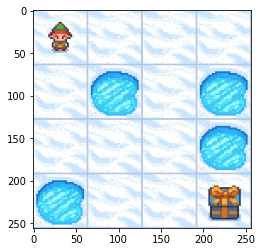

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(img)

#### Explore env

In [30]:
# space of possible action
env.action_space

Discrete(4)

In [31]:
# space of possible observation
env.observation_space

Discrete(16)

In [34]:
# number of possible action
env.action_space.n

4

4 actions :
- 0: left
- 1: down
- 2: right
- 3: up

In [35]:
# number of possible observation
env.observation_space.n

16

Grid 4X4 = 16

### Function to initialize Q-table

Function to initilize Q-table for FrozenLake environment. This Q-table is a table of zeros with dimensions based on the number of possible states and actions in the environment.

Q.shape(number of observations, number of actions)


In [38]:
import numpy

def q_init(env):
    """
        function that initializes the Q-table

        :param env: FrozenLakeEnv instance

        :return: Q-table as a numpy.ndarray of zeros
    """
    # possibles obs
    obs = env.observation_space.n
    # possibles actions
    act = env.action_space.n

    # init Q-table
    q_table = np.zeros((obs, act))

    return q_table

In [39]:
# test q_init function

env = load_frozen_lake()
Q = q_init(env)
print(Q.shape)
env = load_frozen_lake(is_slippery=True)
Q = q_init(env)
print(Q.shape)
desc = [['S', 'F', 'F'], ['F', 'H', 'H'], ['F', 'F', 'G']]
env = load_frozen_lake(desc=desc)
Q = q_init(env)
print(Q.shape)
env = load_frozen_lake(map_name='4x4')
Q = q_init(env)
print(Q.shape)

(64, 4)
(64, 4)
(9, 4)
(16, 4)


### Epsilon-Greedy strategy

In reinforcement learning, the epsilon-greedy strategy is a common approach for balancing exploration and exploitation. The agent decides whether to explore new actions or exploit known actions based on a probability epsilon. With a probability epsilon, the agent explores the environment by selecting a random action. With a probability (1 - epsilon), the agent exploits the knowledge encoded in the Q-table by selecting the action with the highest estimated reward. This method helps the agent learn the optimal policy by exploring various state-action pairs while still leveraging the knowledge it has gained.

#### Epsilon-greedy function
The function `epsilon_greedy` implements the epsilon-greedy strategy. It takes the Q-table, the current state, and the epsilon value as inputs and returns the next action to be taken. The function uses a random uniform distribution to decide whether to explore or exploit. If the agent decides to explore, it selects a random action. Otherwise, it selects the action with the highest Q-value for the current state.

In [40]:
def epsilon_greedy(Q, state, epsilon):
    """
        function that uses epsilon-greedy to determine the next action

        :param Q: ndarray, Q-table
        :param state: current state
        :param epsilon: epsilon use for the calculation

        using random uniform distribution to set if algo explore or exploit
        using random.randint to determine exploration action

        :return: next action index
    """
    # determine if algo explore or exploit
    p = np.random.uniform(0, 1)

    # exploration : random exploration
    if p < epsilon:
        action = np.random.randint(0, Q.shape[1])
    # exploitation (p > epsilon)
    else:
        action = np.argmax(Q[state, :])

    return action

In [45]:
# test epsilon_greedy function
desc = [['S', 'F', 'F'], ['F', 'H', 'H'], ['F', 'F', 'G']]
env = load_frozen_lake(desc=desc)
Q = q_init(env)
Q[7] = np.array([0.5, 0.7, 1, -1])
np.random.seed(0)
print(f"Selected action:{epsilon_greedy(Q, 7, 0.5)}")
np.random.seed(1)
print(f"Selected action: {epsilon_greedy(Q, 7, 0.5)}")

Selected action:2
Selected action: 0


### Q--learning Algorithm
Q-learning is a popular reinforcement learning algorithm used to find the optimal action-selection policy for any given finite Markov decision process. It learns the quality (or Q-values) of state-action pairs, which represent the total expected rewards an agent can accumulate, starting from a state and taking an action. This is done iteratively by updating the Q-values based on the agent's experiences and the Bellman equation.

#### Q-learning Training Function
The `train` function implements the Q-learning algorithm. It takes the environment, Q-table, and several hyperparameters as inputs and returns the updated Q-table and the total rewards accumulated per episode. The function uses the epsilon-greedy strategy for action selection, updating the Q-values and decaying epsilon over time to balance exploration and exploitation.

In [55]:
def train(env, Q, episodes=5000, max_steps=100, alpha=0.1,
          gamma=0.99, epsilon=1, min_epsilon=0.1, epsilon_decay=0.05):
    """
        function to performs Q-learning

    :param env: FrozenLake instance
    :param Q: ndarray, Q-table
    :param episodes: total number of episode to train over
    :param max_steps: max number of steps per episode
    :param alpha: learning rate
    :param gamma: discount rate
    :param epsilon: initial threshold for epsilon greedy
    :param min_epsilon: min value that epsilon should decay to
    :param epsilon_decay: decay rate for updating epsilon between episodes

    :return: Q, total_rewards
        Q: updated Q-table
        total_rewards = list containing the rewards per episode
    """

    total_rewards = []

    for episode in range(episodes):
        episode_rewards = 0

        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        for step in range(max_steps):
            # determined action
            action = epsilon_greedy(Q, state, epsilon)
            # set new_state and associated reward
            next_state, reward, done, _,  info = env.step(action)
            if isinstance(next_state, tuple):
                next_state = next_state[0]

            # update reward if hole
            if done and reward == 0:
                reward = -1

            episode_rewards += reward

            # update Q-table
            next_value = np.max(Q[next_state])
            Q[state, action] *= 1 - alpha
            Q[state, action] += alpha * (reward + gamma * next_value)

            # set new begin state
            state = next_state

            if done:
                break

        # update epsilon
        epsilon = (min_epsilon + (1 - min_epsilon)
                   * np.exp(-epsilon_decay * episode))

        total_rewards.append(episode_rewards)

    return Q, total_rewards

In [57]:
# test of train fonction

np.random.seed(0)
desc = [['S', 'F', 'F'], ['F', 'H', 'H'], ['F', 'F', 'G']]
env = load_frozen_lake(desc=desc)
Q = q_init(env)

Q, total_rewards  = train(env, Q)
print(Q)
split_rewards = np.split(np.array(total_rewards), 10)
for i, rewards in enumerate(split_rewards):
    print((i+1) * 500, ':', np.mean(rewards))

[[ 0.96059593  0.970299    0.95098488  0.96059396]
 [ 0.96059557 -0.77123208  0.0094072   0.37627228]
 [ 0.18061285 -0.1         0.          0.        ]
 [ 0.97029877  0.9801     -0.99999988  0.96059583]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.98009763  0.98009933  0.99        0.9702983 ]
 [ 0.98009922  0.98999782  1.         -0.99999952]
 [ 0.          0.          0.          0.        ]]
500 : 0.812
1000 : 0.88
1500 : 0.9
2000 : 0.9
2500 : 0.88
3000 : 0.844
3500 : 0.892
4000 : 0.896
4500 : 0.852
5000 : 0.928


### Playing th trained Agent
Once we have trained our agent using Q-learning, we can let it play an episode to see how well it performs. The function play is designed for this purpose. It uses the Q-table to select the best actions and navigates through the environment step-by-step.

#### play Function
The `play` function takes the environment, the Q-table, and a maximum number of steps as inputs. It plays one episode by always choosing the action with the highest Q-value for the current state. It renders the environment at each step, showing the agent's movements and updates the total rewards collected during the episode.

In [70]:
def play(env, Q, max_steps=100):
    """
        function that has the trained agent play an episode

    :param env: FrozenLakeEnv instance
    :param Q: ndarray containing Q-table
    :param max_steps: max number of steps in the episode

    :return: total rewards for the episode
    """

    # intitial state
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]

    total_rewards = 0

    for step in range(max_steps):
        # actual state
        env.render()

        # select best action in Q-table
        action = np.argmax(Q[state, :])

        # apply action
        new_state, reward, done, _, info = env.step(action)
        if isinstance(new_state, tuple):
            new_state = new_state[0]

        # update reward
        total_rewards += reward

        # next state
        state = new_state

        if done:
            break

    return total_rewards

In [71]:
# test play function

In [75]:
np.random.seed(0)
desc = [['S', 'F', 'F'], ['F', 'H', 'H'], ['F', 'F', 'G']]
env = load_frozen_lake(desc=desc)
Q = q_init(env)

Q, total_rewards  = train(env, Q)
total_rewards = play(env, Q)
print(f"Total reward from playing one episode: {total_rewards}")

Total reward from playing one episode: 1.0


### Vizualisation

#### Plotting Rewards Over Episodes

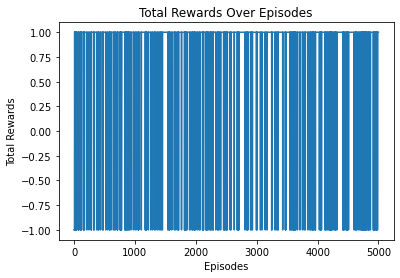

In [76]:
import matplotlib.pyplot as plt

# After training
episodes = 5000
total_rewards = train(env, Q, episodes)[1]

plt.plot(range(episodes), total_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Total Rewards Over Episodes')
plt.show()


#### Visualizing Q-Table

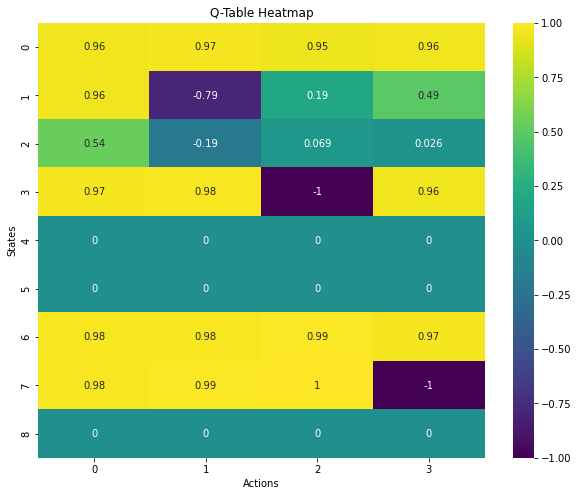

In [79]:
import seaborn as sns

# Assuming Q is the Q-table
plt.figure(figsize=(10, 8))
sns.heatmap(Q, annot=True, cmap="viridis")
plt.xlabel('Actions')
plt.ylabel('States')
plt.title('Q-Table Heatmap')
plt.show()
